In [1]:
import numpy as np
import networkx as nx
import powerlaw 
import netgraph
import matplotlib.pylab as plt
import os
import pickle

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler
#from Qommunity.samplers.regular.bayan_sampler import BayanSampler

from Qommunity.searchers.community_searcher.community_searcher import CommunitySearcher
from Qommunity.searchers.hierarchical_community_searcher import HierarchicalCommunitySearcher

from iterative_searcher.iterative_searcher import IterativeSearcher

type_net = "BA"
os.makedirs(f"./Topology-{type_net}", exist_ok=True)
num_runs = 20
resolution = 1
nodes = [30, 50, 80, 100]
fractions = [.05,0.1,.4,.7]
Gs = {}
scale_free = {}

for n in nodes:
    for f in fractions:
        try:
            Gs[(n,f)] = pickle.load(open(f"./Topology-{type_net}/graph_n={n}_f={f}.pickle", 'rb'))
            print(f"n={n}, f={f}: Graph loaded --> You can reuse already calculated solutions")
        except:
            g = nx.barabasi_albert_graph(n, int(f*n))
            Gs[(n,f)] = g
            pickle.dump(g, open(f"./Topology-{type_net}/graph_n={n}_f={f}.pickle", 'wb'))
            print(f"n={n}, f={f}: Graph generated --> Results should not be loaded now but calculated from scratch")
        
        # Scale free exponent
        pl = powerlaw.Fit([d for _, d in Gs[(n,f)].degree()], discrete=True, estimate_discrete=True)
        scale_free[(n,f)] = pl.power_law.alpha
        print("\n")

N_nets = len(Gs)

n=30, f=0.05: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 80%

n=30, f=0.1: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 87%

n=30, f=0.4: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 93%

n=30, f=0.7: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 92%

n=50, f=0.05: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 88%

n=50, f=0.1: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 93%

n=50, f=0.4: Graph loaded --> You can reuse already calculated solutions
Calculating best minimal value for power law fit
xmin progress: 96%

n=50

In [2]:
### ADVANTAGE ###

adv_modularities = {}
adv_communities = {}
adv_times_elapsed = {}

for (n, f), g in zip(Gs.keys(), Gs.values()):   
    try:
        adv_modularities[(n,f)] = np.load(f"./Topology-{type_net}/solver-adv_runs-{num_runs}_n={n}_f={f}_res={resolution}_modularities.npy")[()]
        adv_communities[(n,f)] = np.load(f"./Topology-{type_net}/solver-adv_runs-{num_runs}_n={n}_f={f}_res={resolution}_communities.npy", allow_pickle=True)[0]
        adv_times_elapsed[(n,f)] = np.load(f"./Topology-{type_net}/solver-adv_runs-{num_runs}_n={n}_f={f}_res={resolution}_times.npy")[()]
        print(f"n={n}, f={f}: Reasults loaded")
    
    except:
        adv_sampler = AdvantageSampler(g, resolution=resolution, num_reads=100, use_clique_embedding=True)
        adv_searcher = HierarchicalCommunitySearcher(adv_sampler)
        adv_iterative = IterativeSearcher(adv_searcher)
        cs_all, mod_all, ts_all = adv_iterative.run(num_runs=num_runs, save_results=False)

        # Only the community with the highest modularity
        adv_communities[(n,f)] = cs_all[mod_all.argmax()]
        adv_modularities[(n,f)] = mod_all.max()
        adv_times_elapsed[(n,f)] = ts_all[mod_all.argmax()]
        
        x = np.empty(shape=(1,), dtype=object)
        x[0] = adv_communities[(n,f)]
        np.save(f"./Topology-{type_net}/solver-adv_runs-{num_runs}_n={n}_f={f}_res={resolution}_modularities.npy", adv_modularities[(n,f)])
        np.save(f"./Topology-{type_net}/solver-adv_runs-{num_runs}_n={n}_f={f}_res={resolution}_communities.npy", x, allow_pickle=True)
        np.save(f"./Topology-{type_net}/solver-adv_runs-{num_runs}_n={n}_f={f}_res={resolution}_times.npy", adv_times_elapsed[(n,f)])

n=30, f=0.05: Reasults loaded
n=30, f=0.1: Reasults loaded
n=30, f=0.4: Reasults loaded
n=30, f=0.7: Reasults loaded
n=50, f=0.05: Reasults loaded
n=50, f=0.1: Reasults loaded
n=50, f=0.4: Reasults loaded
n=50, f=0.7: Reasults loaded
n=80, f=0.05: Reasults loaded
n=80, f=0.1: Reasults loaded
n=80, f=0.4: Reasults loaded
n=80, f=0.7: Reasults loaded
n=100, f=0.05: Reasults loaded
n=100, f=0.1: Reasults loaded
n=100, f=0.4: Reasults loaded
n=100, f=0.7: Reasults loaded


In [3]:
### LOUVAIN ###
try:
    louv_modularities = np.load(f"./Topology-{type_net}/solver-louv_runs-{num_runs}_res={resolution}_modularities.npy", allow_pickle=True)[()]
    louv_communities = np.load(f"./Topology-{type_net}/solver-louv_runs-{num_runs}_res={resolution}_communities.npy", allow_pickle=True)[()]
    louv_times_elapsed = np.load(f"./Topology-{type_net}/solver-louv_runs-{num_runs}_res={resolution}_times.npy", allow_pickle=True)[()]
    print(f"Reasults loaded")

except:
    louv_modularities = {}
    louv_communities = {}
    louv_times_elapsed = {}
    
    for (n, f), g in zip(Gs.keys(), Gs.values()):
        louv_sampler = LouvainSampler(g, resolution=resolution)
        louv_searcher = CommunitySearcher(louv_sampler)
        louv_iterative = IterativeSearcher(louv_searcher)
        cs_all, mod_all, ts_all = louv_iterative.run(num_runs=num_runs, save_results=False)

        # Only the community with the highest modularity
        louv_communities[(n,f)] = cs_all[mod_all.argmax()]
        louv_modularities[(n,f)] = mod_all.max()
        louv_times_elapsed[(n,f)] = ts_all[mod_all.argmax()]

    np.save(f"./Topology-{type_net}/solver-louv_runs-{num_runs}_res={resolution}_modularities.npy", louv_modularities, allow_pickle=True)
    np.save(f"./Topology-{type_net}/solver-louv_runs-{num_runs}_res={resolution}_communities.npy", louv_communities, allow_pickle=True)
    np.save(f"./Topology-{type_net}/solver-louv_runs-{num_runs}_res={resolution}_times.npy", louv_times_elapsed, allow_pickle=True)

Reasults loaded


In [4]:
### LEIDEN ###
try:
    leid_modularities = np.load(f"./Topology-{type_net}/solver-leid_runs-{num_runs}_res={resolution}_modularities.npy", allow_pickle=True)[()]
    leid_communities = np.load(f"./Topology-{type_net}/solver-leid_runs-{num_runs}_res={resolution}_communities.npy", allow_pickle=True)[()]
    leid_times_elapsed = np.load(f"./Topology-{type_net}/solver-leid_runs-{num_runs}_res={resolution}_times.npy", allow_pickle=True)[()]
    print(f"Reasults loaded")

except:
    leid_modularities = {}
    leid_communities = {}
    leid_times_elapsed = {}
    
    for (n, f), g in zip(Gs.keys(), Gs.values()):
        leid_sampler = LeidenSampler(g)
        leid_searcher = CommunitySearcher(leid_sampler)
        leid_iterative = IterativeSearcher(leid_searcher)
        cs_all, mod_all, ts_all = leid_iterative.run(num_runs=num_runs, save_results=False)

        # Only the community with the highest modularity
        leid_communities[(n,f)] = cs_all[mod_all.argmax()]
        leid_modularities[(n,f)] = mod_all.max()
        leid_times_elapsed[(n,f)] = ts_all[mod_all.argmax()]

    np.save(f"./Topology-{type_net}/solver-leid_runs-{num_runs}_res={resolution}_modularities.npy", leid_modularities, allow_pickle=True)
    np.save(f"./Topology-{type_net}/solver-leid_runs-{num_runs}_res={resolution}_communities.npy", leid_communities, allow_pickle=True)
    np.save(f"./Topology-{type_net}/solver-leid_runs-{num_runs}_res={resolution}_times.npy", leid_times_elapsed, allow_pickle=True)

Reasults loaded


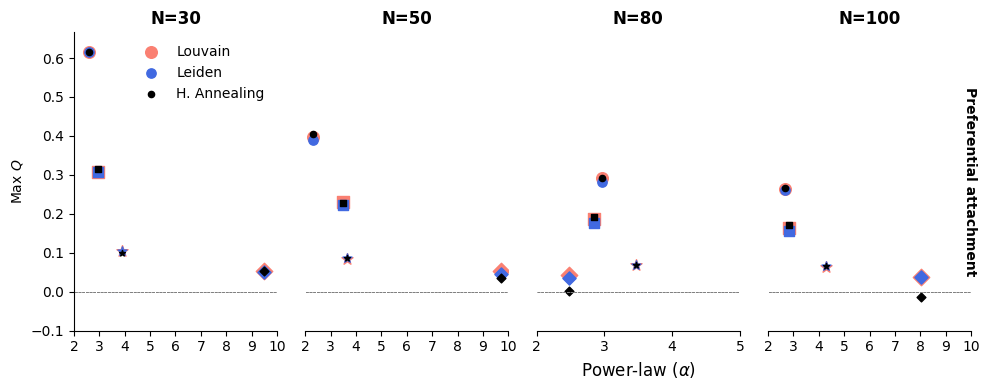

In [5]:
fig, ax = plt.subplots(1,4,figsize=(10,4))
marks = {.05:'o', .1:'s', .4:'*', .7:'D'}
axes = {30:0, 50:1, 80:2, 100:3}

for i, (n,f) in enumerate(Gs.keys()):
    alpha_exp = scale_free[(n,f)]    
    ax[axes[n]].hlines(0,0,12,color='gray',linestyle='--',linewidth=.5)
    ax[axes[n]].scatter(alpha_exp, louv_modularities[(n,f)], marker=marks[f], color='salmon', s=70, label="Louvain" if i==0 else None)
    ax[axes[n]].scatter(alpha_exp, leid_modularities[(n,f)], marker=marks[f], color='royalblue', s=45, label="Leiden" if i==0 else None)
    if (n,f) in adv_modularities.keys():
        ax[axes[n]].scatter(alpha_exp, adv_modularities[(n,f)], marker=marks[f], color='black', s=20, label="H. Annealing" if i==0 else None)

for n in nodes:
    ax[axes[n]].set_title(f"N={n}",fontsize=12, fontweight='bold')
    ax[axes[n]].set_ylim([-.1,max(louv_modularities.values())+.05])
    if axes[n]==0:
        ax[axes[n]].legend(frameon=False)
        ax[axes[n]].spines[["top","right"]].set_visible(False)
        ax[axes[n]].set_ylabel("Max "+r'$Q$')
    else:
        ax[axes[n]].spines[["top","right", "left"]].set_visible(False)
        ax[axes[n]].set_yticks([])
    if axes[n]==2:
        ax[axes[n]].set_xticks(range(2,6))
        ax[axes[n]].set_xlim([2,5])
        ax[axes[n]].set_xlabel("Power-law "+r'($\alpha)$', fontsize=12)
    else:
        ax[axes[n]].set_xticks(range(2,11))
        ax[axes[n]].set_xlim([2,10])
    if axes[n]==3:
        ax[axes[n]].set_ylabel("Preferential attachment", fontweight='bold', rotation=270)
        ax[axes[n]].yaxis.set_label_position("right")
        ax[axes[n]].yaxis.tick_right()

fig.tight_layout()
plt.savefig(f"Topology-{type_net}/scale-free_performance-algos.svg", format='svg', dpi=200)

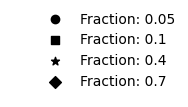

In [6]:
# just to have a legend
fig, ax = plt.subplots(1,1,figsize=(2,1))
for f in fractions:
    ax.scatter(np.nan, np.nan, marker=marks[f], label=f"Fraction: {f}",color='black')
ax.spines[["top","right","bottom","left"]].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.legend(frameon=False)
plt.savefig(f"Topology-{type_net}/fraction_legend.svg", format='svg', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


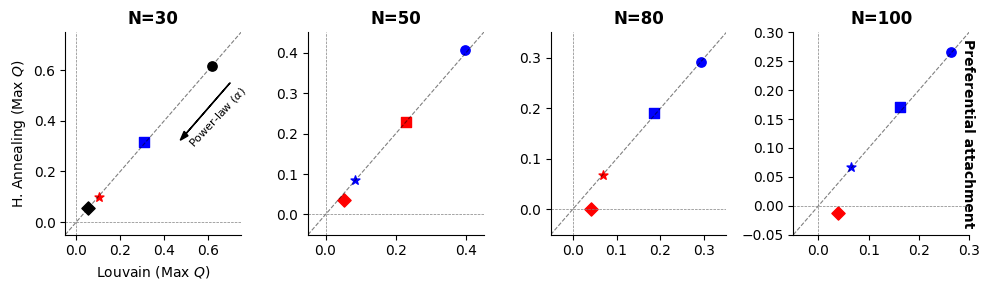

In [7]:
fig, ax = plt.subplots(1,4,figsize=(10,3))
xlims = {30:.75, 50:.45, 80:.35, 100:.3}
def map_to_color(a,b):
    if a==b:
        return 'black'
    elif a>b:
        return 'blue'
    else:
        return 'red'

for i, (n,f) in enumerate(Gs.keys()):
    if (n,f) in adv_modularities.keys():
        ax[axes[n]].scatter(louv_modularities[(n,f)], adv_modularities[(n,f)], marker=marks[f], color=map_to_color(adv_modularities[(n,f)], louv_modularities[(n,f)]), s=45)
        
for n in nodes:
    ax[axes[n]].plot(np.linspace(-.05,1,2), np.linspace(-.05,1,2), linestyle='--', linewidth=.8, color="black", alpha=.5)
    ax[axes[n]].set_title(f"N={n}",fontsize=12, fontweight='bold')
    ax[axes[n]].set_ylim([0,max(louv_modularities.values())+.05])
    ax[axes[n]].set_xlim([-.05, xlims[n]])
    ax[axes[n]].set_ylim([-.05, xlims[n]])
    ax[axes[n]].spines[["top","right"]].set_visible(False)
    ax[axes[n]].vlines(0,-.05,xlims[n],color='gray',linestyle='--',linewidth=.5)
    ax[axes[n]].hlines(0,-.05,xlims[n],color='gray',linestyle='--',linewidth=.5)
    
    if axes[n]==0:
        ax[axes[n]].legend(frameon=False)
        ax[axes[n]].set_ylabel("H. Annealing (Max "+r'$Q$)')
        ax[axes[n]].set_xlabel("Louvain (Max "+r'$Q$)')
        ax[axes[n]].arrow(xlims[n]-.05,xlims[n]-.2,-.2,-.2, head_width=.025, facecolor='black')
        ax[axes[n]].text(xlims[n]-.25,xlims[n]-.45, "Power-law "+r'($\alpha)$', rotation=47, fontsize=8)
    if axes[n]==3:
        ax[axes[n]].set_ylabel("Preferential attachment", fontweight='bold', rotation=270)
        ax[axes[n]].yaxis.set_label_position("right")

fig.tight_layout()
plt.savefig(f"Topology-{type_net}/Hannealing_louvain.svg", format='svg', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


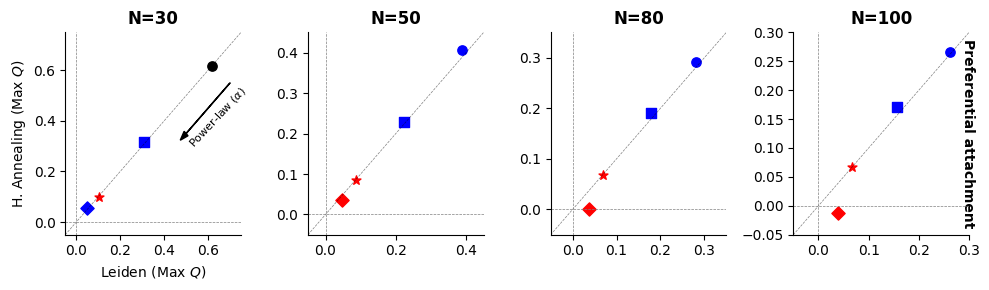

In [8]:
fig, ax = plt.subplots(1,4,figsize=(10,3))
xlims = {30:.75, 50:.45, 80:.35, 100:.3}
def map_to_color(a,b):
    if a==b:
        return 'black'
    elif a>b:
        return 'blue'
    else:
        return 'red'

for i, (n,f) in enumerate(Gs.keys()):
    if (n,f) in adv_modularities.keys():
        ax[axes[n]].scatter(leid_modularities[(n,f)], adv_modularities[(n,f)], marker=marks[f], color=map_to_color(adv_modularities[(n,f)], leid_modularities[(n,f)]), s=45)

for n in nodes:
    ax[axes[n]].plot(np.linspace(-.05,1,2), np.linspace(-.05,1,2), linestyle='--', linewidth=.5, color="black", alpha=.5)
    ax[axes[n]].set_title(f"N={n}",fontsize=12, fontweight='bold')
    ax[axes[n]].set_ylim([0,max(louv_modularities.values())+.05])
    ax[axes[n]].set_xlim([-.05, xlims[n]])
    ax[axes[n]].set_ylim([-.05, xlims[n]])
    ax[axes[n]].spines[["top","right"]].set_visible(False)
    ax[axes[n]].vlines(0,-.05,xlims[n],color='gray',linestyle='--',linewidth=.5)
    ax[axes[n]].hlines(0,-.05,xlims[n],color='gray',linestyle='--',linewidth=.5)
    
    if axes[n]==0:
        ax[axes[n]].legend(frameon=False)
        ax[axes[n]].set_ylabel("H. Annealing (Max "+r'$Q$)')
        ax[axes[n]].set_xlabel("Leiden (Max "+r'$Q$)')
        ax[axes[n]].arrow(xlims[n]-.05,xlims[n]-.2,-.2,-.2, head_width=.025, facecolor='black')
        ax[axes[n]].text(xlims[n]-.25,xlims[n]-.45, "Power-law "+r'($\alpha)$', rotation=47, fontsize=8)
    
    if axes[n]==3:
        ax[axes[n]].set_ylabel("Preferential attachment", fontweight='bold', rotation=270)
        ax[axes[n]].yaxis.set_label_position("right")

fig.tight_layout()
plt.savefig(f"Topology-{type_net}/Hannealing_leiden.svg", format='svg', dpi=200)

In [218]:
import scipy.stats as ss
import statsmodels.api as sm

# We compute the relative increase
rel_increase_louv = []
rel_increase_leid = []
nodes_louvain = []
nodes_leiden = []
alphas = []
for i, (n,f) in enumerate(Gs.keys()):
    if (n,f) in adv_modularities.keys():
        rel_increase_leid.append(100*(adv_modularities[(n,f)]-leid_modularities[(n,f)])/leid_modularities[(n,f)])
        rel_increase_louv.append(100*(adv_modularities[(n,f)]-louv_modularities[(n,f)])/louv_modularities[(n,f)])
        alphas.append(scale_free[(n,f)])
        nodes_louvain.append(n)
        nodes_leiden.append(n)
rel_increase_louv = np.array(rel_increase_louv)
rel_increase_leid = np.array(rel_increase_leid)
alphas = np.array(alphas)
nodes_louvain = np.array(nodes_louvain)
nodes_leiden = np.array(nodes_leiden)

# Zscoring to detect outliers
rel_z_louv = ss.zscore(rel_increase_louv)
rel_z_leid = ss.zscore(rel_increase_leid)
alpha_z = ss.zscore(alphas)
z_lim = 1.96

# Deleting outliers
rels_louv = rel_increase_louv[(np.abs(alpha_z)<1.96)*(np.abs(rel_z_louv)<z_lim)]
rels_leid = rel_increase_leid[(np.abs(alpha_z)<1.96)*(np.abs(rel_z_leid)<z_lim)]
alphas_louv = alphas[(np.abs(alpha_z)<1.96)*(np.abs(rel_z_louv)<z_lim)]
alphas_leid = alphas[(np.abs(alpha_z)<1.96)*(np.abs(rel_z_leid)<z_lim)]
nodes_louv = nodes_louvain[(np.abs(alpha_z)<1.96)*(np.abs(rel_z_louv)<z_lim)]
nodes_leid = nodes_leiden[(np.abs(alpha_z)<1.96)*(np.abs(rel_z_leid)<z_lim)]

# Concatenating for a joint linear regression
alpha_regress = np.concatenate((alphas_louv,alphas_leid))
rel_increase_regress = np.concatenate((rels_louv,rels_leid))
nodes_regres = np.concatenate((nodes_louv, nodes_leid))

# Bilinear model to see the effect of network size and topology
X = np.vstack((alpha_regress, nodes_regres)).T
X = sm.add_constant(X)
model = sm.OLS(rel_increase_regress, X)
results = model.fit()
print("Model: increase ~ 1 + alpha + nodes")
print("R-squared: ", results.rsquared)
print("P-value of the F-statistic: ", results.f_pvalue)
print("Coefficients: ", results.params)
print("T-values: ", results.tvalues)
print("P-values: ", results.pvalues)
print("AIC: ", results.info_criteria('aic'))
print("BIC: ", results.info_criteria('bic'))
print("========================")
# Bilinear model plus interaction to see the effect of network size and topology
X = np.vstack((alpha_regress, nodes_regres, alpha_regress*nodes_regres)).T
X = sm.add_constant(X)
model = sm.OLS(rel_increase_regress, X)
results = model.fit()
print("Model: increase ~ 1 + alpha + nodes + alpha*nodes")
print("R-squared: ", results.rsquared)
print("P-value of the F-statistic: ", results.f_pvalue)
print("Coefficients: ", results.params)
print("T-values: ", results.tvalues)
print("P-values: ", results.pvalues)
print("AIC: ", results.info_criteria('aic'))
print("BIC: ", results.info_criteria('bic'))

Model: increase ~ 1 + alpha + nodes
R-squared:  0.36802191214382673
P-value of the F-statistic:  0.008079253140927504
Coefficients:  [ 6.94985762 -2.68380377  0.04624621]
T-values:  [ 2.08620691 -2.76577907  2.27193685]
P-values:  [0.04934131 0.01158367 0.03372261]
AIC:  118.25727727603676
BIC:  121.79143876708059
Model: increase ~ 1 + alpha + nodes + alpha*nodes
R-squared:  0.386916813135605
P-value of the F-statistic:  0.018440567379299545
Coefficients:  [12.63058065 -4.47056345 -0.03704054  0.02609732]
T-values:  [ 1.583051   -1.80439413 -0.34279483  0.78510475]
P-values:  [0.1290955  0.08625157 0.73532947 0.44159378]
AIC:  119.52877908739646
BIC:  124.24099440878824


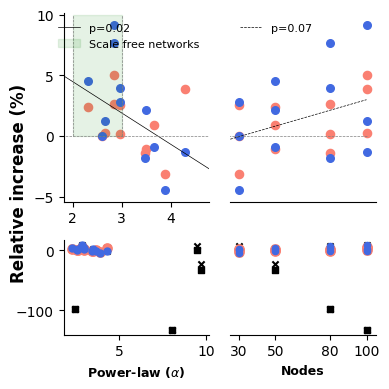

In [220]:
# Only power-law exponent fit
X = alpha_regress.T
X = sm.add_constant(X)
model = sm.OLS(rel_increase_regress, X)
results_alpha = model.fit()
# Only number of nodes fit
X = nodes_regres.T
X = sm.add_constant(X)
model = sm.OLS(rel_increase_regress, X)
results_nodes = model.fit()

fig, ax = plt.subplots(2,2,figsize=(4,4), gridspec_kw={'height_ratios':[2,1]})

ax[0,0].spines[["top","right"]].set_visible(False)
ax[0,0].scatter(alphas_louv, rels_louv, color="salmon", s=35)
ax[0,0].scatter(alphas_leid, rels_leid, color='royalblue', s=30)
ax[0,0].plot(np.linspace(0,10,2),results_alpha.params[1]*np.linspace(0,10,2) + results_alpha.params[0], color='black', linewidth=.5, label=f"p={np.round(results_alpha.pvalues[1],2)}")
ax[0,0].hlines(0,0,100,color='gray',linestyle='--',linewidth=.5)
ax[0,0].vlines(2,0,10,color='gray',linestyle='--',linewidth=.5)
ax[0,0].vlines(3,0,10,color='gray',linestyle='--',linewidth=.5)
ax[0,0].fill_between([2,3],[10,10], alpha=.1, color='green', label='Scale free networks')
ax[0,0].set_ylim([min(rel_increase_regress)-1, max(rel_increase_regress)+1])
ax[0,0].set_xlim([min(alpha_regress)-.5, max(alpha_regress)+.5])
ax[0,0].set_ylabel("Relative increase (%)", fontsize=12, fontweight='bold', verticalalignment='bottom',y=0.1)
ax[0,0].legend(frameon=False, fontsize=8)

ax[0,1].spines[["top","right","left"]].set_visible(False)
ax[0,1].scatter(nodes_louv, rels_louv, color="salmon", s=35)
ax[0,1].scatter(nodes_leid, rels_leid, color='royalblue', s=30)
ax[0,1].plot(np.linspace(0,100,2),results_nodes.params[1]*np.linspace(0,100,2) + results_nodes.params[0], '--', color='black', linewidth=.5, label=f"p={np.round(results_nodes.pvalues[1],2)}")
ax[0,1].hlines(0,0,100,color='gray',linestyle='--',linewidth=.5)
ax[0,1].set_ylim([min(rel_increase_regress)-1, max(rel_increase_regress)+1])
ax[0,1].set_yticks([])
ax[0,1].set_xlim([nodes[0]-5, nodes[-1]+5])
ax[0,1].set_xticks([])
ax[0,1].legend(frameon=False, fontsize=8)

ax[1,0].spines[["top","right"]].set_visible(False)
ax[1,0].scatter(alphas, rel_increase_louv, marker='s', color='black', s=20)
ax[1,0].scatter(alphas, rel_increase_leid, marker='x', color='black', s=20)
ax[1,0].scatter(alphas_louv, rels_louv, color='salmon', s=45)
ax[1,0].scatter(alphas_leid, rels_leid, color='royalblue', s=25)
ax[1,0].set_xlim([min(alphas)-.5, max(alphas)+.5])
ax[1,0].set_xlabel("Power-law " + r'($\alpha$)', fontweight='bold', fontsize=9)

ax[1,1].spines[["top","right","left"]].set_visible(False)
ax[1,1].scatter(nodes_louvain, rel_increase_louv, marker='s', color='black', s=20)
ax[1,1].scatter(nodes_leiden, rel_increase_leid, marker='x', color='black', s=20)
ax[1,1].scatter(nodes_louv, rels_louv, color='salmon', s=45)
ax[1,1].scatter(nodes_leid, rels_leid, color='royalblue', s=20)
ax[1,1].set_yticks([])
ax[1,1].set_xticks(nodes)
ax[1,1].set_xlim([nodes[0]-5, nodes[-1]+5])
ax[1,1].set_xlabel("Nodes", fontweight='bold', fontsize=9)

fig.tight_layout()
plt.savefig(f"Topology-{type_net}/relative_increase.svg", format='svg', dpi=200)